# Evaluating performance of scalable GPLVM models for dimensionality reduction of single-cell genomics datasets
---

In [1]:
from TrainFunction import plot_cormap, scatter_Plot, CorrelationScores
import scanpy as sc
import os, torch
import numpy as np
import pandas as pd
import pickle as pkl
import scipy.sparse as sp
from collections import namedtuple
import seaborn as sns
from scipy.stats import pearsonr
import matplotlib.pyplot as plt
import sklearn

In [2]:
## Load output of trained GPLVMs (12 in total)

In [3]:
gastrulation=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/gastrulation_PCA.h5ad')

In [4]:
gastrulation_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/gastrulation_random.h5ad')

| Dataset     | Gastrulation|
| ----------- | ----------- |
| No of Cells | 89267        |
| No of Genes | 1488       |
|Time         | 9 minutes       |

In [5]:
forebrain=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/forebrain_PCA.h5ad')

In [6]:
forebrain

AnnData object with n_obs × n_vars = 1720 × 2454
    obs: 'Clusters', 'cellcycle_pseudotime'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca'
    obsm: 'X_BGPLVM_latent', 'X_pca'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'

In [7]:
forebrain_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/forebrain_random.h5ad')

| Dataset     | Forebrain|
| ----------- | ----------- |
| No of Cells | 1720       |
| No of Genes | 2454     |
|Time         | ~13 minutes       |

In [8]:
bonemarrow=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/bonemarrow_PCA.h5ad')

In [9]:
bonemarrow_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/bonemarrow_random.h5ad')

| Dataset     | Bonemarrow|
| ----------- | ----------- |
| No of Cells | 5780        |
| No of Genes |  2030|    |
|Time         |~12 mins        |

In [10]:
iPSC=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/iPSC_PCA.h5ad')

In [11]:
iPSC_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/iPSC_random.h5ad')

| Dataset     |iPSC|
| ----------- | ----------- |
| No of Cells |    22188    |
| No of Genes | 1404 |    |
|Time         |~8:50 mins        |

In [12]:
pancreas=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/pancreas_PCA.h5ad')

In [13]:
pancreas_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/pancreas_random.h5ad')

| Dataset     |Pancreas|
| ----------- | ----------- |
| No of Cells | 3696       |
| No of Genes | 1939 |    |
|Time         |~11 mins        |

In [14]:
pbmc=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/pbmc_PCA.h5ad')

In [15]:
pbmc_random=sc.read_h5ad('/home/jupyter/GPLVM_Shaista/TrainedModels/pbmc_random.h5ad')

| Dataset     |iPSC|
| ----------- | ----------- |
| No of Cells |    65877  |
| No of Genes | 1721    |
|Time         |~10 mins        |

## Do we require non-random initialization of the GPLVM model?

In the GASPACHO paper we used PCA as the inital state, but is this really necessary?

### 1. GPLVM initialized from the PCA doesn't learn anything different

In [16]:
## ... correlation between PCs and LVs with and without initialization

In [17]:
datasets=[bonemarrow,bonemarrow_random, forebrain,forebrain_random, gastrulation, gastrulation_random, iPSC, iPSC_random, pancreas
          ,pancreas_random,pbmc,pbmc_random]

In [18]:
len(datasets)

12

In [19]:
Names=['bonemarrow','bonemarrow_random', 'forebrain','forebrain_random', 'gastrulation', 'gastrulation_random', 'iPSC', 
       'iPSC_random', 'pancreas','pancreas_random','pbmc','pbmc_random']

In [20]:
data= pd.DataFrame(columns=["Correlation", "dataset", "Init"])

In [21]:
for i in range(12):
    tempDf = pd.DataFrame(columns=['Correlation','dataset','Init'])
    tempDf['Correlation'] = CorrelationScores(datasets[i],7)
    tempDf = tempDf.assign(dataset=Names[i])
    if '_' in Names[i]:
        tempDf['Correlation'] = CorrelationScores(datasets[i],7)
        tempDf = tempDf.assign(dataset=Names[i])
        tempDf= tempDf.assign(Init="random")
        data = pd.concat([data,tempDf])
    else:
        tempDf['Correlation'] = CorrelationScores(datasets[i],7)
        tempDf = tempDf.assign(dataset=Names[i])
        tempDf= tempDf.assign(Init="PCA")
        data = pd.concat([data,tempDf])   

In [22]:
d=data.copy()
d=d.replace('pbmc_random','pbmc')
d=d.replace('bonemarrow_random','bonemarrow')
d=d.replace('iPSC_random','iPSC')
d=d.replace('forebrain_random','forebrain')
d=d.replace('pancreas_random','pancreas')
d=d.replace('gastrulation_random','gastrulation')

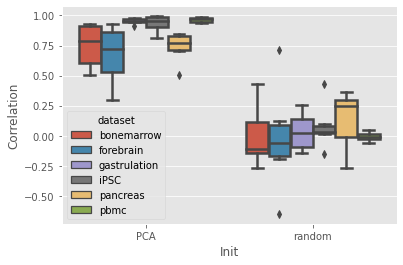

In [23]:
ax = sns.boxplot(x="Init", y="Correlation", hue="dataset",
                 data=d, linewidth=2.5)

### 2. Does GPLVM trained with random initialization capture cell type identity?

As a first impression we can visualize UMAP embeddings from all the dimensionality reductions (random GPLVM, initialized GPLM, PCA) and assess qualitatively if we see a separation between cells of the same cell type

In [24]:
## code for UMAP plots ##

In [25]:
 #sc.tl.pca(adata, svd_solver='arpack')

In [27]:
def plot_umap(adata,adata_random):
    '''
    plots umaps based on the GP(random-init), GP(PCA-init) and PC components, takes as input adata objects with trained GP models 
    based on PC and random initialisation respectively 
    '''
    #del adata.obsm['X_umap'] #delete exisiting UMAPs
    #del adata_random.obsm['X_umap']
    
    sc.pp.neighbors(adata, use_rep="X_pca", key_added='PCA') #use_rep=any values from obsm
    sc.tl.umap(adata,neighbors_key='PCA')
    adata.obsm["X_umap_pca"] = adata.obsm["X_umap"].copy()
    
    sc.pp.neighbors(adata_random, use_rep="X_BGPLVM_latent", key_added='gplvm_random') 
    sc.tl.umap(adata_random, neighbors_key='gplvm_random')
    adata.obsm["X_umap_gplvm_random"] = adata_random.obsm["X_umap"].copy()
    adata_random.obsm["X_umap_gplvm_rand"] = adata_random.obsm["X_umap"].copy()

    sc.pp.neighbors(adata, use_rep="X_BGPLVM_latent", key_added='gplvm_PCA') 
    sc.tl.umap(adata, neighbors_key='gplvm_PCA')
    adata.obsm["X_umap_gplvm_PC"] = adata.obsm["X_umap"].copy()

    
    sc.tl.leiden(adata, neighbors_key='gplvm_PCA', key_added='clusters_gplvm_PcaInit')
    sc.tl.leiden(adata_random, neighbors_key='gplvm_random', key_added='clusters_gplvm_randomInit')
    sc.tl.leiden(adata, neighbors_key='PCA', key_added='clusters_PC')
    adata.obs["clusters_gplvm_randomInit"] = adata_random.obs["clusters_gplvm_randomInit"].copy()



    
    return adata
    
    

In [28]:
plot_umap(forebrain,forebrain_random)

AnnData object with n_obs × n_vars = 1720 × 2454
    obs: 'Clusters', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'ambiguous', 'matrix', 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

In [29]:
plot_umap(gastrulation, gastrulation_random)

AnnData object with n_obs × n_vars = 89267 × 1488
    obs: 'barcode', 'sample', 'stage', 'sequencing.batch', 'theiler', 'doub.density', 'doublet', 'cluster', 'cluster.sub', 'cluster.stage', 'cluster.theiler', 'stripped', 'celltype', 'colour', 'umapX', 'umapY', 'haem_gephiX', 'haem_gephiY', 'haem_subclust', 'endo_gephiX', 'endo_gephiY', 'endo_trajectoryName', 'endo_trajectoryDPT', 'endo_gutX', 'endo_gutY', 'endo_gutDPT', 'endo_gutCluster', 'cell_velocyto_loom', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA

In [30]:
plot_umap(bonemarrow,bonemarrow_random)

AnnData object with n_obs × n_vars = 5780 × 2030
    obs: 'clusters', 'palantir_pseudotime', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_colors', 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_tsne', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

In [31]:
plot_umap(iPSC,iPSC_random)

AnnData object with n_obs × n_vars = 22188 × 1404
    obs: 'nfrag', 'ngene', 'donor', 'mt', 'ercc', 'plate', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_init', 'X_pca', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

In [32]:
plot_umap(pbmc,pbmc_random)

AnnData object with n_obs × n_vars = 65877 × 1721
    obs: 'celltype', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_tsne', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

In [33]:
plot_umap(pancreas,pancreas_random)

AnnData object with n_obs × n_vars = 3696 × 1939
    obs: 'clusters_coarse', 'clusters', 'S_score', 'G2M_score', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'highly_variable_genes', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'clusters_coarse_colors', 'clusters_colors', 'day_colors', 'hvg', 'likelihood_state_dict', 'model_state_dict', 'neighbors', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'connectivities', 'distances', 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

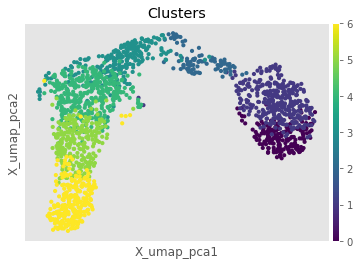

In [34]:
sc.pl.embedding(forebrain, "X_umap_pca", color=[ 'Clusters'])

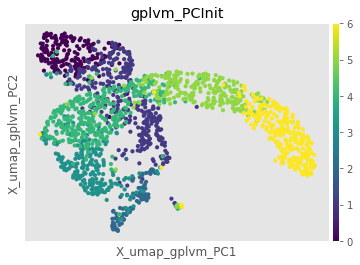

In [35]:
sc.pl.embedding(forebrain, "X_umap_gplvm_PC", color=[ 'Clusters'], title="gplvm_PCInit") #PCA

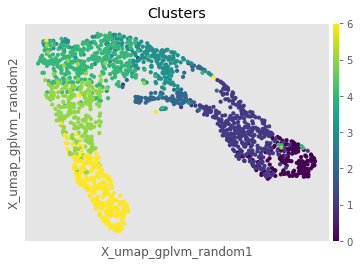

In [36]:
sc.pl.embedding(forebrain, "X_umap_gplvm_random", color=['Clusters']) #PCA

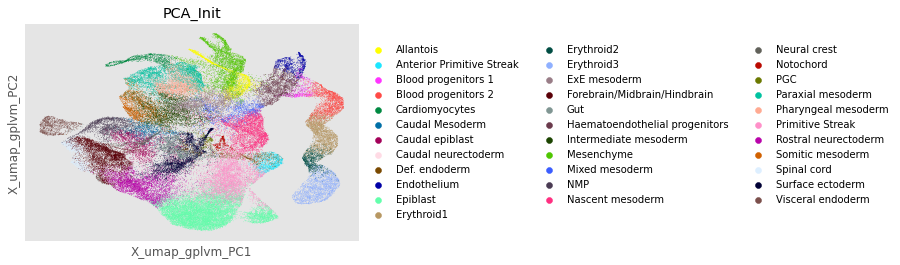

In [39]:
sc.pl.embedding(gastrulation, "X_umap_gplvm_PC", color=[ 'celltype'], title="PCA_Init")

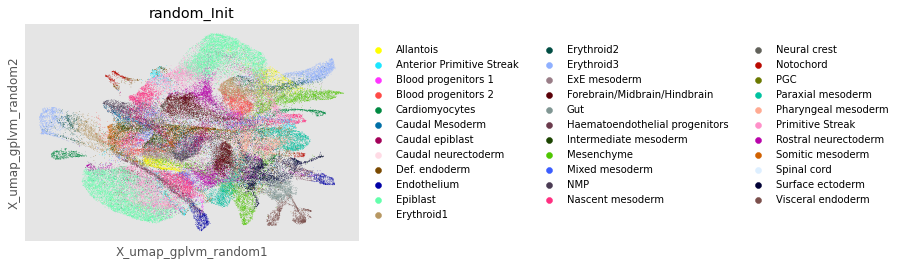

In [40]:
sc.pl.embedding(gastrulation, "X_umap_gplvm_random", color=[ 'celltype'], title="random_Init")

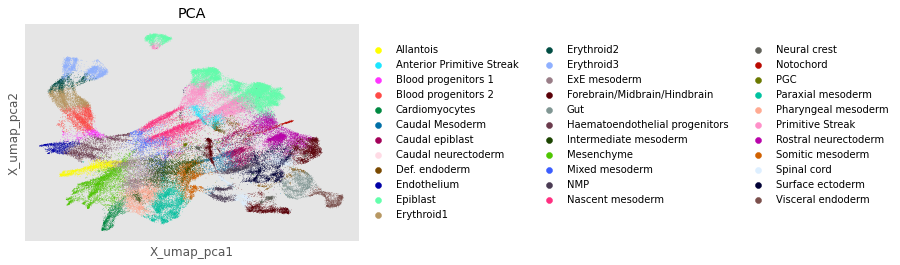

In [41]:
sc.pl.embedding(gastrulation, "X_umap_pca", color=[ 'celltype'], title="PCA")

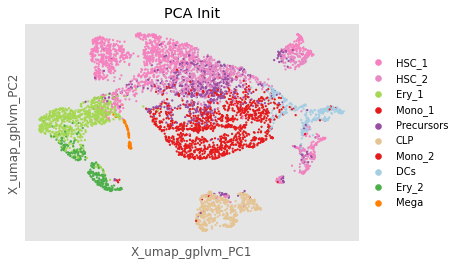

In [43]:
gp_pca=sc.pl.embedding(bonemarrow, "X_umap_gplvm_PC", color=['clusters'], title="PCA Init")

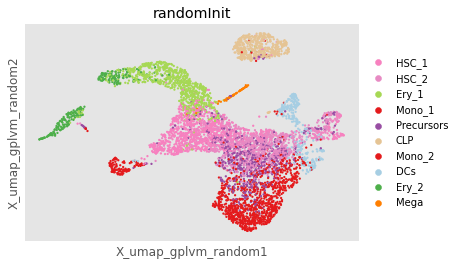

In [45]:
gp_rand=sc.pl.embedding(bonemarrow, "X_umap_gplvm_random", color=[ 'clusters'], title= "randomInit")

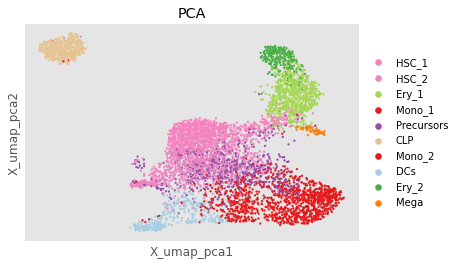

In [44]:
pca=sc.pl.embedding(bonemarrow, "X_umap_pca", color=[ 'clusters'], title="PCA")

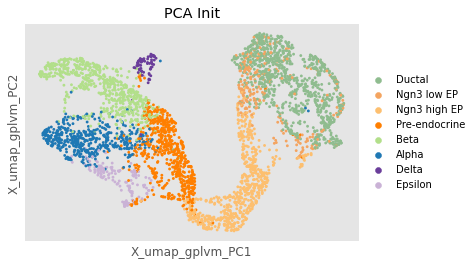

In [51]:
gp_pca=sc.pl.embedding(pancreas, "X_umap_gplvm_PC", color=['clusters'], title="PCA Init")

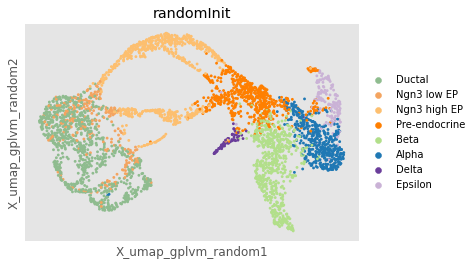

In [49]:
sc.pl.embedding(pancreas, "X_umap_gplvm_random", color=['clusters'], title="randomInit") #PCA

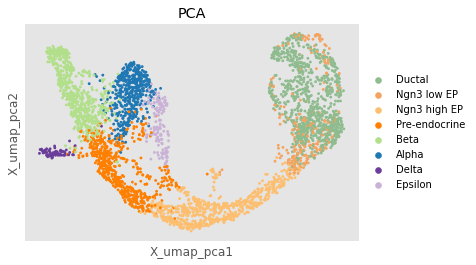

In [52]:
gp_pca=sc.pl.embedding(pancreas, "X_umap_pca", color=['clusters'], title="PCA")

In [57]:
pbmc

AnnData object with n_obs × n_vars = 65877 × 1721
    obs: 'celltype', 'cellcycle_pseudotime', 'clusters_gplvm_PcaInit', 'clusters_PC', 'clusters_gplvm_randomInit'
    var: 'Accession', 'Chromosome', 'End', 'Start', 'Strand', 'highly_variable', 'means', 'dispersions', 'dispersions_norm'
    uns: 'hvg', 'likelihood_state_dict', 'model_state_dict', 'pca', 'PCA', 'umap', 'gplvm_PCA', 'leiden'
    obsm: 'X_BGPLVM_latent', 'X_pca', 'X_tsne', 'X_umap', 'X_umap_pca', 'X_umap_gplvm_random', 'X_umap_gplvm_PC'
    varm: 'PCs'
    layers: 'spliced', 'unspliced'
    obsp: 'PCA_distances', 'PCA_connectivities', 'gplvm_PCA_distances', 'gplvm_PCA_connectivities'

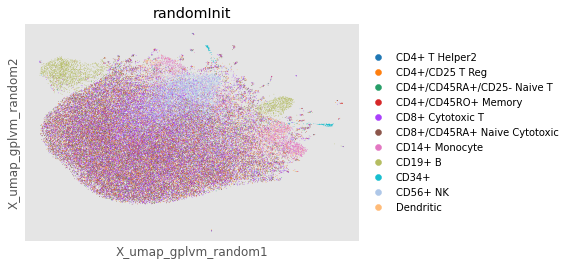

In [61]:
sc.pl.embedding(pbmc, "X_umap_gplvm_random", color=['celltype'], title="randomInit")

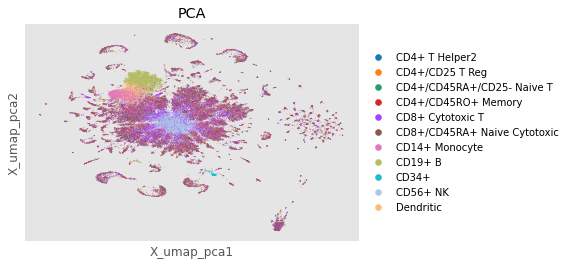

In [62]:
gp_pca=sc.pl.embedding(pbmc, "X_umap_pca", color=['celltype'], title="PCA")

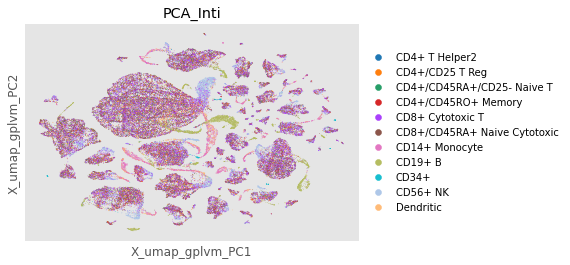

In [63]:
sc.pl.embedding(pbmc, "X_umap_gplvm_PC", color=['celltype'], title="PCA_Inti")

In [66]:
ARI_gplvm_rand =sklearn.metrics.adjusted_rand_score(gastrulation_random.obs['celltype'], gastrulation_random.obs['clusters_gplvm_randomInit'])
ARI_gplvm_init = sklearn.metrics.adjusted_rand_score(gastrulation.obs['celltype'], gastrulation.obs['clusters_gplvm_PcaInit'])
ARI_pca = sklearn.metrics.adjusted_rand_score(gastrulation.obs['celltype'], gastrulation.obs['clusters_PC'])
print(ARI_gplvm_rand)
print(ARI_gplvm_init)
print(ARI_pca)

0.2608154016825488
0.47560275453397044
0.40074279764434667


In [67]:
ARI_gplvm_rand =sklearn.metrics.adjusted_rand_score(forebrain_random.obs['Clusters'], forebrain_random.obs['clusters_gplvm_randomInit'])
ARI_gplvm_init = sklearn.metrics.adjusted_rand_score(forebrain.obs['Clusters'], forebrain.obs['clusters_gplvm_PcaInit'])
ARI_pca = sklearn.metrics.adjusted_rand_score(forebrain.obs['Clusters'], forebrain.obs['clusters_PC'])
print(ARI_gplvm_rand)
print(ARI_gplvm_init)
print(ARI_pca)

0.44745767355904503
0.35276673597729513
0.5219759376242143


In [69]:
ARI_gplvm_rand =sklearn.metrics.adjusted_rand_score(pancreas_random.obs['clusters'], pancreas_random.obs['clusters_gplvm_randomInit'])
ARI_gplvm_init = sklearn.metrics.adjusted_rand_score(pancreas.obs['clusters'], pancreas.obs['clusters_gplvm_PcaInit'])
ARI_pca = sklearn.metrics.adjusted_rand_score(pancreas.obs['clusters'], pancreas.obs['clusters_PC'])
print(ARI_gplvm_rand)
print(ARI_gplvm_init)
print(ARI_pca)

0.3186019134265437
0.34134381854054086
0.4466812149787457


In [70]:
ARI_gplvm_rand =sklearn.metrics.adjusted_rand_score(bonemarrow_random.obs['clusters'], bonemarrow_random.obs['clusters_gplvm_randomInit'])
ARI_gplvm_init = sklearn.metrics.adjusted_rand_score(bonemarrow.obs['clusters'], bonemarrow.obs['clusters_gplvm_PcaInit'])
ARI_pca = sklearn.metrics.adjusted_rand_score(bonemarrow.obs['clusters'], bonemarrow.obs['clusters_PC'])
print(ARI_gplvm_rand)
print(ARI_gplvm_init)
print(ARI_pca)

0.32008087763115367
0.29011396971167713
0.5134324188492745


In [71]:
ARI_gplvm_rand =sklearn.metrics.adjusted_rand_score(pbmc_random.obs['celltype'], pbmc.obs['clusters_gplvm_randomInit'])
ARI_gplvm_init = sklearn.metrics.adjusted_rand_score(pbmc.obs['celltype'], pbmc.obs['clusters_gplvm_PcaInit'])
ARI_pca = sklearn.metrics.adjusted_rand_score(pbmc.obs['celltype'], pbmc.obs['clusters_PC'])
print(ARI_gplvm_rand)
print(ARI_gplvm_init)
print(ARI_pca)

0.03565037669388883
0.01636115278719417
0.06891238622599233


We can quantify the agreement between clusters obtained with distance on the LVs with ground truth cell type labels from a range of datasets, using metrics for [clustering evaluation](https://scikit-learn.org/stable/modules/clustering.html#clustering-performance-evaluation) implemented in `sklearn` (e.g. Adjusted Rand Index and Normalized Mutual Information). We then compare the ARI and NMI values we get from GP latent variables with those that we get from clustering on PCs.

In [47]:
ARI_gplvm_rand

0.44745767355904503

In [48]:
ARI_pca

0.5219759376242143

In [63]:
ARI_gplvm_init

0.35276673597729513

In [ ]:
## dummy code just to have an idea, I have not run this

# Cluster cells based on GPLVM dimensions (with random initialization)
sc.pp.neighbors(adata, use_rep="X_GPLVM_random", key_added='gplvm_random') #yse_rep=any vaoue from obsm
sc.tl.leiden(adata, neighbors_key='gplvm_random', key_added='clusters_GPLVM_random')

# Cluster cells based on GPLVM dimensions (with PCA initialization)
sc.pp.neighbors(adata, use_rep="X_GPLVM_init", key_added='gplvm_init')
sc.tl.leiden(adata, neighbors_key='gplvm_init', key_added='clusters_GPLVM_init')

# Cluster cells based on PC dimensions
sc.pp.neighbors(adata, use_rep="X_pca", key_added='pca')
sc.tl.leiden(adata, neighbors_key='pca', key_added='clusters_PCA')

# Compute agreement metrics
## Adjusted Rand Index
ARI_gplvm_rand = metrics.adjusted_rand_score(adata.obs['celltype'], adata.obs['clusters_GPLVM_random'])
ARI_gplvm_init = metrics.adjusted_rand_score(adata.obs['celltype'], adata.obs['clusters_GPLVM_random'])
ARI_pca = metrics.adjusted_rand_score(adata.obs['celltype'], adata.obs['clusters_PCA'])
## Normalized Mutual Information
# ...

Here `ARI_pca` and `ARI_gplvm_init` should be rather similar, but are they higher than `ARI_gplvm_rand`? It might also make sense to compute each metric for each celltype cluster, to have a distribution of values rather than a single score

In [ ]:
## summarise results from multiple datasets in one plot

At the end of this analysis we should be able to tell whether the random initialization of GPLVM is as good as PCA as a dimensionality reduction strategy for scRNA-seq data, or whether initialization is needed to capture cell type identity. 

## Part 2: incorporating a latent variable with periodic prior in the GPLVM model allows to correct cell cycle effects

Having shown that GPLVMs (either with or without initialization) can perform the same tasks that PCA performs on scRNA-seq datasets, we now turn to evaluating the advantages of this model. One of the main advantages is that we can assign informative priors on some of the latent variables to better disentangle nuisance effects in gene expression data. One such effect is the cell cycle: by incorporating a latent variable with periodic kernel, we force that variable to capture the main "cyclic" effect in the dataset.

### 1. Does the variable with periodic kernel really capture the cell cycle?
Remember the model has no idea what the cell cycle is or which genes are related to it

In [3]:
## Plot scatter plots or heatmap of cell cycle pseudotime VS expression of cell cycle genes 

### 2. When we exclude the latent variable capturing the cell cycle, does this reduce separation between cells in different stages in clustering?

For this analysis we start by using the pancreas dataset in the scvelo package, where we observed that the clustering and embedding based on PCA still retains separation between cells driven by proliferation (are there more datasets like this?).

We want to evaluate whether excluding the cell cycle latent variable creates a reduced dimensionality space where cells with the same label but different proliferation status are well mixed, while still maintaining differences. We need to define a metric to quantify mixing (examples metrics to quantify batch mixing [here](https://github.com/theislab/scib#metrics)). 

In [ ]:
## Code to identify proliferating cells

In [ ]:
## Code to quantify mixing between proliferating cells of the same type

As an additional positive control, we can check how much the mixing is reduced if we do include the cell cycle latent variable